# Imports

In [3]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, ttest_1samp
import scipy.stats as stats

# General variables

 ## Filenames

In [4]:
# Define the pattern of filenames

GameTheoretic_filename_pattern_DQN =  re.compile(r"results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_DQN_"
                                                r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
                                                r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
                                                r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
                                                r"(?P<batch_size>[\d.]+)_(?P<hidden_size>[\d.]+)_(?P<update_target_every>[\d.]+)_"
                                                r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

GameTheoretic_filename_pattern_QL = re.compile(r"results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_QLearning_"
                                              r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
                                              r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
                                              r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
                                              r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)


Maze2D_filename_order_QL = re.compile(
    r"maze2d_results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_QLearning_"
    r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
    r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
    r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
    r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

Maze2D_filename_order_DQN = re.compile(
    r"maze2d_results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_DQN_"
    r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
    r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
    r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
    r"(?P<batch_size>[\d.]+)_(?P<hidden_size>[\d.]+)_(?P<update_target_every>[\d.]+)_"
    r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

FILENAME_PATTERNS = [
    GameTheoretic_filename_pattern_DQN,
    GameTheoretic_filename_pattern_QL,
    Maze2D_filename_order_DQN,
    Maze2D_filename_order_QL
]

FILENAME_PATTERNS_PAIR = [
    ("Gametheoretic", GameTheoretic_filename_pattern_DQN),
    ("Gametheoretic", GameTheoretic_filename_pattern_QL),
    ("maze2d", Maze2D_filename_order_DQN),
    ("maze2d", Maze2D_filename_order_QL)
]

# Functions

## CSV processing

### Parameter recovery from filenames

In [5]:
def parse_results_filenames(folder_path: str, filename_patterns=None) -> pd.DataFrame:
    """
    Scans a folder for result filenames and extracts simulation parameters into a DataFrame.

    Args:
        folder_path (str): Path to the folder containing result CSV files.
        filename_patterns (list): List of compiled regex patterns to match filenames.
                                  If None, use global FILENAME_PATTERNS.

    Returns:
        pd.DataFrame: DataFrame containing parsed parameters from filenames.
    """
    if filename_patterns is None:
        filename_patterns = FILENAME_PATTERNS

    data = []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".csv"):
            continue

        matched = False
        for pattern in filename_patterns:
            match = pattern.match(filename)
            if match:
                file_data = match.groupdict()
                file_data["filename"] = filename
                data.append(file_data)
                matched = True
                break  # Stop at the first match
        
        if not matched:
            print(f"Warning: filename did not match any pattern: {filename}")

    if not data:
        print("No matching filenames found.")
        return pd.DataFrame()

    df = pd.DataFrame(data)

    # Optional: convert numeric fields from str to float/int
    for col in df.columns:
        if col not in {"filename", "emotion", "see_emotions", "suffix"}:
            try:
                df[col] = pd.to_numeric(df[col])
            except Exception:
                pass  # leave as string if conversion fails

    return df

In [6]:
def print_unique_parameter_values(df: pd.DataFrame, exclude: list = None):
    """
    Print a table with parameter names and their unique values.

    Args:
        df (pd.DataFrame): The input DataFrame with simulation parameters.
        exclude (list): Optional list of column names to exclude (e.g., ['filename', 'simulation_index']).
    """
    if exclude is None:
        exclude = ['filename', 'simulation_index']

    param_cols = [col for col in df.columns if col not in exclude]

    summary = {
        "parameter": [],
        "unique_values": []
    }

    for col in param_cols:
        summary["parameter"].append(col)
        summary["unique_values"].append(sorted(df[col].dropna().unique().tolist()))

    summary_df = pd.DataFrame(summary)
    print(summary_df)


In [7]:
import pandas as pd

def compute_alpha_from_df(df: pd.DataFrame, nb_agents: int, verbose: bool = False) -> float:
    """
    Estimate alpha from a DataFrame containing total personal, empathic, and combined rewards
    for multiple agents. Alpha is estimated as:
        alpha = (combined - personal) / (empathic - personal)
    
    Args:
        df (pd.DataFrame): Input DataFrame containing the reward columns.
        nb_agents (int): Number of agents.
        verbose (bool): If True, print alpha stats per agent.
    
    Returns:
        float: Estimated average alpha.
    """
    alphas = []
    
    for agent_idx in range(nb_agents):
        personal_col = f"total_personal_reward_{agent_idx}"
        empathic_col = f"total_empathic_reward_{agent_idx}"
        combined_col = f"total_combined_reward_{agent_idx}"
        
        # Validate presence of required columns
        for col in [personal_col, empathic_col, combined_col]:
            if col not in df.columns:
                raise KeyError(f"Missing column: {col}")
        
        personal = df[personal_col].astype(float)
        empathic = df[empathic_col].astype(float)
        combined = df[combined_col].astype(float)
        
        denominator = empathic - personal
        valid_mask = denominator != 0
        
        if valid_mask.sum() == 0:
            print(f"⚠️ No valid rows for agent {agent_idx} (division by zero in alpha computation)")
            continue
        
        alpha_agent = (combined[valid_mask] - personal[valid_mask]) / denominator[valid_mask]
        alpha_agent = alpha_agent[(alpha_agent >= 0) & (alpha_agent <= 1)]  # optional filtering
        alphas.append(alpha_agent)
        
        if verbose:
            print(f"[Agent {agent_idx}] alpha mean: {alpha_agent.mean():.4f}, samples: {len(alpha_agent)}")
    
    if not alphas:
        raise ValueError("No valid alpha values could be computed.")
    
    all_alphas = pd.concat(alphas)
    mean_alpha = all_alphas.mean()
    print(f"\n✅ Estimated average alpha from CSV data: {mean_alpha:.4f}")
    
    return mean_alpha

### Aggregation of csv

In [8]:
def aggregate_results_by_suffix(folder_path: str, target_suffix: str, environment_type: str = None) -> pd.DataFrame:
    '''
    arg: 
        folder_path : way to access the folder containing the csv
        target_suffix : ending name of the csv => "episode_summary" or "step_data"
        environment_type : "gametheoretic" or "maze2d"

    return: 
        agregated dataframe
    '''
    all_data = []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".csv"):
            continue

        for source_type, pattern in FILENAME_PATTERNS_PAIR:
            if environment_type and source_type.lower() != environment_type.lower():
                continue

            match = pattern.match(filename)
            if match:
                metadata = match.groupdict()
                if metadata.get("suffix", "").strip() == target_suffix.strip():
                    file_path = os.path.join(folder_path, filename)
                    try:
                        df = pd.read_csv(file_path)
                        for key, value in metadata.items():
                            df[key] = value
                        df["source"] = source_type.lower()  # normalize
                        all_data.append(df)
                    except Exception as e:
                        print(f"Error reading {filename}: {e}")
                break

    if not all_data:
        print(f"No matching files found for suffix '{target_suffix}' and source '{environment_type}'.")
        return pd.DataFrame()

    final_df = pd.concat(all_data, ignore_index=True)

    for col in final_df.columns:
        if col not in {"emotion", "see_emotions", "suffix", "filename", "source"}:
            try:
                final_df[col] = pd.to_numeric(final_df[col])
            except:
                pass

    filtered_tag = f"_{environment_type.lower()}" if environment_type else ""
    output_filename = f"aggregated_{target_suffix}{filtered_tag}.csv"
    output_path = os.path.join(folder_path, output_filename)
    final_df.to_csv(output_path, index=False)
    print(f"Saved aggregated data to: {output_path}")

    return final_df


In [9]:

def sum_columns_by_format(df: pd.DataFrame, 
                          prefix: str, 
                          new_column_name: str = None) -> None:
    """
    Adds a new column to the DataFrame that contains the row-wise sum of all columns 
    matching the pattern '{prefix}_i', where 'i' is an integer.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify (the operation is done in place).
        prefix (str): The prefix of the target columns (e.g., 'total_combined_reward').
        new_column_name (str, optional): The name of the new column to add.
                                         Defaults to '{prefix}_sum' if not specified.
    """
    pattern = re.compile(rf"^{re.escape(prefix)}_(\d+)$")
    matching_cols = [col for col in df.columns if pattern.match(col)]

    if not matching_cols:
        raise ValueError(f"No columns found with prefix '{prefix}_<i>'")

    if new_column_name is None:
        new_column_name = f"Sum_{prefix}"

    df[new_column_name] = df[matching_cols].sum(axis=1)

    return df

In [10]:
def summarize_simulations(df_summary: pd.DataFrame) -> pd.DataFrame:
    """
    Summarizes per-episode data into one row per simulation with computed metrics.

    Parameters:
        df_summary (pd.DataFrame): A DataFrame with per-episode simulation results.

    Returns:
        pd.DataFrame: A summary with one row per simulation.
    """
    required_columns = [
        'simulation_index', 'alpha', 'see_emotions', 'total_steps',
        'initial_resources', 'max_steps', 'resource_remaining',
        'total_personal_reward__averaged_efficiency', 'gini_coef'
    ]

    missing = [col for col in required_columns if col not in df_summary.columns]
    if missing:
        raise ValueError(f"Missing columns in input DataFrame: {missing}")

    df_sim = (
        df_summary
        .groupby(['simulation_index', 'alpha', 'see_emotions'])
        .agg(
            total_steps=('total_steps', 'sum'),
            initial_resources=('initial_resources', 'sum'), 
            max_steps=('max_steps', 'sum'),
            resource_remaining=('resource_remaining', 'sum'),
            total_efficiency=('total_personal_reward__averaged_efficiency', 'sum'),
            gini_coef=('gini_coef', 'mean'),
        )
        .assign(
            step_number_depletion=lambda df: 1 - (df['total_steps'] / df['max_steps']),
            resource_quantity_depletion=lambda df: 1 - (df['resource_remaining'] / df['initial_resources']),
            efficiency_metric=lambda df: df['total_efficiency'] / df['total_steps'],
        )
        .reset_index()
        .rename(columns={'simulation_index': 'simulation_number'})
        [[
            'simulation_number', 'alpha', 'see_emotions', 'total_steps', 'initial_resources',
            'step_number_depletion', 'resource_quantity_depletion', 'efficiency_metric', 'gini_coef'
        ]]
    )

    return df_sim


## Data analysis

 ### Learning verification

In [11]:
def windowed_avg_combined_reward(
    df: pd.DataFrame,
    reward_prefix: str = "total_combined_reward_",
    episode_column: str = "episode",
    simulation_id_column: str = "simulation_index",
    window_size: int = 5,
    aggregation_mode: str = "mean",  # or "best"
    plot: bool = False,
    title: str = None,
    legend: str = None
) -> pd.DataFrame:
    """
    Computes a windowed moving average of reward (or any scalar metric) per episode across simulations.

    Args:
        df (pd.DataFrame): Input dataframe.
        reward_prefix (str): Prefix or full column name. If a full column name is given, used directly.
        episode_column (str): Column name for episodes.
        simulation_id_column (str): Column indicating different simulations.
        window_size (int): Window size for moving average.
        aggregation_mode (str): 'mean' or 'best' (only applies to multiple-agent columns).
        plot (bool): Whether to plot the result.

    Returns:
        pd.DataFrame: DataFrame with ['episode', 'mean_reward', 'moving_avg'].
    """
    if title is None:
        title = f'Windowed Avg: {reward_prefix}{aggregation_mode}'
    if legend is None:
        legend = f"Windowed Avg Smoothing: {window_size} episodes"

    # Detect if reward_prefix is an exact column name (single-column case)
    if reward_prefix in df.columns:
        df["aggregated_reward"] = df[reward_prefix]
    else:
        # Handle multi-agent reward columns like total_combined_reward_0, ..., _5
        reward_cols = [col for col in df.columns if col.startswith(reward_prefix)]
        if not reward_cols:
            raise ValueError(f"No reward columns found with prefix '{reward_prefix}'")

        if aggregation_mode == "mean":
            df["aggregated_reward"] = df[reward_cols].mean(axis=1)
        elif aggregation_mode == "best":
            df["aggregated_reward"] = df[reward_cols].max(axis=1)
        else:
            raise ValueError("aggregation_mode must be 'mean' or 'best'")

    # Group by episode to get average across simulations
    episode_avg = (
        df.groupby(episode_column)["aggregated_reward"]
        .mean()
        .reset_index()
        .rename(columns={"aggregated_reward": "mean_reward"})
    )

    # Apply centered moving average smoothing
    episode_avg["moving_avg"] = (
        episode_avg["mean_reward"].rolling(window=window_size, min_periods=1, center=True).mean()
    )

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(episode_avg[episode_column], episode_avg["moving_avg"], label=legend)
        plt.xlabel("Episode")
        plt.ylabel("Reward" if "reward" in reward_prefix else reward_prefix.replace('_', ' ').title())
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return episode_avg


In [12]:
def compute_episode_reward_correlation(
    df: pd.DataFrame, 
    reward_column: str = 'total_personal_reward', 
    simulation_column: str = 'simulation_index', 
    type_column: str = 'alpha'
) -> pd.DataFrame:
    """
    Computes correlation between episode number and total reward across simulations, split by type.
    If residuals are normally distributed (Shapiro-Wilk p >= 0.05), uses Pearson correlation.
    Otherwise, uses Spearman correlation.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing simulation results.
        reward_column (str): Column with total reward per episode.
        simulation_column (str): Column identifying the simulation.
        type_column (str): Column distinguishing between the two types (e.g., 'alpha').
        
    Returns:
        pd.DataFrame: DataFrame with simulation ID, type, correlation, p-value, test used, and sample size.
    """
    results = []

    if 'episode' not in df.columns:
        raise ValueError("DataFrame must include an 'episode' column.")

    grouped = df.groupby([simulation_column, type_column])

    for (sim_id, sim_type), group in grouped:
        if group['episode'].nunique() > 1:
            # Fit linear regression to compute residuals
            slope, intercept, _, _, _ = stats.linregress(group['episode'], group[reward_column])
            predicted = intercept + slope * group['episode']
            residuals = group[reward_column] - predicted

            # Test residuals normality
            shapiro_stat, shapiro_p = stats.shapiro(residuals)

            if shapiro_p >= 0.05:
                # Residuals normal => use Pearson
                corr, p_value = stats.pearsonr(group['episode'], group[reward_column])
                test_used = 'Pearson'
            else:
                # Residuals not normal => use Spearman
                corr, p_value = stats.spearmanr(group['episode'], group[reward_column])
                test_used = 'Spearman'

            results.append({
                'simulation': sim_id,
                'type': sim_type,
                'correlation': corr,
                'p_value': p_value,
                'test_used': test_used,
                'shapiro_stat': shapiro_stat,
                'shapiro_p': shapiro_p,
                'n_episodes': len(group)
            })

    return pd.DataFrame(results)

### Variable_calculation

#### Gini coefficient

In [13]:
def gini_coefficient(arr: np.ndarray) -> float:
    """Compute Gini coefficient of a 1D numpy array."""
    arr = arr.flatten()
    if np.amin(arr) < 0:
        arr = arr - np.amin(arr)  # Shift if negative values present
    mean = np.mean(arr)
    if mean == 0:
        return 0.0
    n = len(arr)
    diff_sum = np.sum(np.abs(np.subtract.outer(arr, arr)))
    gini = diff_sum / (2 * n**2 * mean)
    return gini

def parse_value(val):
    # If value is a string that looks like a list, parse it
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, (list, tuple, np.ndarray)):
                return np.array(parsed, dtype=float)
            else:
                return float(parsed)
        except (ValueError, SyntaxError):
            # Not a list or can't parse, try converting directly
            return float(val)
    # If already numeric or array, convert accordingly
    elif isinstance(val, (list, tuple, np.ndarray)):
        return np.array(val, dtype=float)
    else:
        return float(val)

def compute_gini_for_df(df: pd.DataFrame, prefix: str) -> pd.Series:
    """
    Compute Gini coefficient across columns starting with prefix for each row in df.
    
    Args:
        df: pandas DataFrame.
        prefix: string prefix for target columns.
        
    Returns:
        pandas Series with Gini coefficients per row.
    """
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        raise ValueError(f"No columns found starting with prefix '{prefix}'")

    def row_gini(row):
        values = []
        for val in row.values:
            parsed_val = parse_value(val)
            # If parsed_val is an array, flatten it, else just append
            if isinstance(parsed_val, np.ndarray):
                values.extend(parsed_val.flatten())
            else:
                values.append(parsed_val)
        values = np.array(values, dtype=float)
        return gini_coefficient(values)








        

    gini_series = df[cols].apply(row_gini, axis=1)
    return gini_series


#### Efficiency

In [14]:
import ast

def compute_efficiency_for_df(df: pd.DataFrame, prefix: str, new_column_name: str) -> pd.DataFrame:
    """
    Compute the average across columns starting with a given prefix for each row in df.
    Handles string representations of single-element lists like '[-1.]'.

    Args:
        df (pd.DataFrame): Input DataFrame.
        prefix (str): Prefix for selecting target columns.
        new_column_name (str): Name of the new column to store the computed average.

    Returns:
        pd.DataFrame: DataFrame with the new column added.
    """
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        raise ValueError(f"No columns found starting with prefix '{prefix}'")

    for col in cols:
        # Clean column: parse strings like '[-1.]' into float -1.0
        def parse_cell(val):
            if isinstance(val, (float, int)):
                return float(val)
            if isinstance(val, str):
                try:
                    parsed = ast.literal_eval(val)
                    if isinstance(parsed, list) and len(parsed) == 1:
                        return float(parsed[0])
                    return float(parsed)  # just in case it's not a list
                except Exception:
                    raise ValueError(f"Value '{val}' in column '{col}' could not be parsed to float.")
            raise ValueError(f"Unsupported value type {type(val)} in column '{col}'.")

        df[col] = df[col].apply(parse_cell)

    df[new_column_name] = df[cols].mean(axis=1)
    return df


#### Ressource depletion

In [15]:
def clean_initial_resources_column(df: pd.DataFrame, column: str = 'initial_resources') -> None:
    """Ensure the initial resource column contains numeric values."""
    def parse_value(x):
        if pd.isna(x):
            return np.nan
        try:
            val = ast.literal_eval(x) if isinstance(x, str) else x
            if isinstance(val, (list, tuple)) and val:
                return float(val[0])
            return float(val)
        except:
            return np.nan

    if column in df.columns and df[column].dtype == object:
        df[column] = df[column].apply(parse_value)
        df[column] = pd.to_numeric(df[column], errors='coerce')


def compute_resource_quantity_depletion(df: pd.DataFrame) -> None:
    """
    Compute the proportion of resource quantity depleted at the end of each episode.
    Adds a column: 'resource_quantity_depletion'
    """
    clean_initial_resources_column(df, 'initial_resources')

    group_keys = ['simulation_index', 'episode']
    grouped = df.groupby(group_keys)

    depletion_df = grouped.agg(
        ending_resource=('resource_remaining', 'last'),
        starting_resource=('initial_resources', 'first')
    ).reset_index()

    depletion_df['resource_quantity_depletion'] = 1 - depletion_df['ending_resource'] / depletion_df['starting_resource']

    df_merged = df.merge(depletion_df[group_keys + ['resource_quantity_depletion']], on=group_keys, how='left')
    df['resource_quantity_depletion'] = df_merged['resource_quantity_depletion']


def compute_step_number_depletion(df: pd.DataFrame) -> None:
    """
    Compute how early the episode ended due to resource depletion.
    Adds a column: 'step_number_depletion'
    """
    clean_initial_resources_column(df, 'initial_resources')

    df['resource_quantity_depletion'] = 1 - df['resource_remaining'] / df['initial_resources']
    df['step_number_depletion'] = 1 - df['total_steps'] / df['max_steps']


### Data visualization

In [16]:
def plot_mean_and_range_across_simulations(
    df: pd.DataFrame,
    value_col: str,               
    simulation_col: str = 'seed',
    episode_col: str = 'episode',
    step_col: str = 'step',
    is_step_csv: bool = False,
    title: str = None,
    ylabel: str = None,
    rolling_window: int = None,
    plot_individual: bool = False  
):
    if is_step_csv:
        group_cols = [simulation_col, episode_col, step_col]
        avg_group_cols = [episode_col, step_col]
    else:
        group_cols = [simulation_col, episode_col]
        avg_group_cols = [episode_col]

    sim_stats = df.groupby(group_cols)[value_col].mean().reset_index()

    agg_funcs = {value_col: ['mean', 'min', 'max']}
    summary = sim_stats.groupby(avg_group_cols).agg(agg_funcs)
    summary.columns = ['mean', 'min', 'max']
    summary = summary.reset_index()

    if rolling_window and rolling_window > 1:
        summary['mean'] = summary['mean'].rolling(rolling_window, min_periods=1, center=True).mean()
        summary['min'] = summary['min'].rolling(rolling_window, min_periods=1, center=True).mean()
        summary['max'] = summary['max'].rolling(rolling_window, min_periods=1, center=True).mean()

    plt.figure(figsize=(10, 6))

    if plot_individual:
        for sim_id, sim_df in sim_stats.groupby(simulation_col):
            x = sim_df[episode_col] if not is_step_csv else sim_df[step_col]
            y = sim_df[value_col]
            if rolling_window:
                y = y.rolling(rolling_window, min_periods=1).mean()
            plt.plot(x, y, color='gray', alpha=0.3, label=f"Sim {sim_id}")

    x_vals = summary[episode_col] if not is_step_csv else summary[step_col]

    plt.fill_between(
        x_vals,
        summary['min'],
        summary['max'],
        color='blue',
        alpha=0.2,
        label='Étendue (min-max)'
    )

    plt.plot(x_vals, summary['mean'], color='blue', linewidth=2, label='Moyenne')

    plt.xlabel('Episode' if not is_step_csv else 'Step')
    plt.ylabel(ylabel if ylabel else value_col)
    plt.title(title or f"Fluctuation moyenne de {value_col} avec étendue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
def plot_avg_steps_to_depletion(
    df: pd.DataFrame,
    steps_col: str = 'steps_to_depletion',  # column with steps to depletion
    episode_col: str = 'episode',
    rolling_window: int = 5,
    title: str = "Fluctuation of Average Steps to Environment Depletion",
    ylabel: str = "Average Steps to Depletion",
    figsize: tuple = (10, 6)
):
    """
    Plot the fluctuation of average steps to depletion over episodes.
    
    Args:
        df: DataFrame containing steps to depletion data.
        steps_col: Column with steps until depletion.
        episode_col: Episode column.
        rolling_window: Window size for smoothing.
        title: Plot title.
        ylabel: Y-axis label.
        figsize: Figure size.
    """
    summary = df.groupby(episode_col)[steps_col].mean().reset_index()

    # Apply rolling smoothing if requested
    if rolling_window > 1:
        summary['steps_smoothed'] = summary[steps_col].rolling(
            rolling_window, min_periods=1, center=True).mean()
    else:
        summary['steps_smoothed'] = summary[steps_col]

    plt.figure(figsize=figsize)
    plt.plot(
        summary[episode_col], 
        summary['steps_smoothed'], 
        marker='o', linestyle='-', color='tab:green', label='Smoothed avg steps'
    )
    plt.scatter(
        summary[episode_col], 
        summary[steps_col], 
        color='tab:gray', alpha=0.6, label='Raw avg steps'
    )
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Analysis of data

## Processing of data

In [18]:
# --- 1. Gather metadata from filenames ---
#folder_path = "GT_simulation_jerome_thesis" 
folder_path = "Evann_csv_results" # Folder containing the CSV results
if not os.path.exists(folder_path):
    print("the folder does not exist :", folder_path)
parameter_dataframe = parse_results_filenames(folder_path=folder_path)

print(parameter_dataframe.head())

desired_params = [
    "emotion", "see_emotions", "alpha", "beta", "smoothing", "threshold",
    "learning_rate", "gamma", "epsilon", "epsilon_decay", "epsilon_min",
    "batch_size", "hidden_size", "update_target_every"
]

param_cols = [col for col in parameter_dataframe.columns if col in desired_params]
unique_values_per_param = {col: sorted(parameter_dataframe[col].unique()) for col in param_cols}

# Convert to DataFrame with param names as columns and unique set of values as rows
max_len = max(len(v) for v in unique_values_per_param.values())
for k in unique_values_per_param:
    unique_values_per_param[k] += [None] * (max_len - len(unique_values_per_param[k]))

# Display of the unique sets of parameter values
summary_df = pd.DataFrame(unique_values_per_param)
print(summary_df.to_string(index=False))

   simulation_index  episodes  emotion see_emotions  alpha  beta smoothing  \
0                 0      5000  average        False    0.0   0.5    linear   
1                 0      5000  average         True    0.5   0.5    linear   
2                 1      5000  average        False    0.0   0.5    linear   
3                 1      5000  average         True    0.5   0.5    linear   
4                 2      5000  average        False    0.0   0.5    linear   

   threshold  rounder  learning_rate  gamma  epsilon  epsilon_decay  \
0        0.5        2          0.001   0.99      1.0          0.995   
1        0.5        2          0.001   0.99      1.0          0.995   
2        0.5        2          0.001   0.99      1.0          0.995   
3        0.5        2          0.001   0.99      1.0          0.995   
4        0.5        2          0.001   0.99      1.0          0.995   

   epsilon_min  batch_size  hidden_size  update_target_every  random_suffix  \
0         0.01          1

In [19]:
# --- Aggregate data for Maze2D --- # add parameter to make the csv_maker not necessary
df_maze_summary = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="episode_summary", # suffix is the ending name of the csv : "episode_summary" OR "step_data"
    environment_type="maze2d" # name of the environment tested : "maze2d" OR "GameTheoretic"
)

df_maze_step = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="step_data",
    environment_type="maze2d"
)

# --- Aggregate data for GameTheoretic environment only ---
df_gt_summary = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="episode_summary",
    environment_type="Gametheoretic"
)

df_gt_step = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="step_data",
    environment_type="Gametheoretic"
)

Saved aggregated data to: Evann_csv_results\aggregated_episode_summary_maze2d.csv
No matching files found for suffix 'step_data' and source 'maze2d'.
No matching files found for suffix 'episode_summary' and source 'Gametheoretic'.
No matching files found for suffix 'step_data' and source 'Gametheoretic'.


### Calculation of Dependent Variables

In [20]:
# sets the name of the columns to compute the gini coefficient and utility over
personal_column_gt_step_prefix = "personal_reward_"
personal_column_gt_summary_prefix = "total_personal_reward_"
personal_column_maze_step_prefix = "personal_reward_"
personal_column_maze_summary_prefix = "total_personal_reward_"


try:
    print([col for col in df_maze_summary.columns if col.startswith(personal_column_maze_step_prefix)])
    df_maze_summary["gini_coef"] = compute_gini_for_df(df_maze_summary, prefix="total_personal_reward_")
    print('succesfull for 2D summary')
except Exception as e:
    print(f"Could not compute Gini for df_maze_summary: {e}")

try:
    print([col for col in df_maze_step.columns if col.startswith(personal_column_maze_step_prefix)])
    df_maze_step["gini_coef"] = compute_gini_for_df(df_maze_step, prefix=personal_column_gt_step_prefix)
    print('succesfull for 2D step')
except Exception as e:
    print(f"Could not compute Gini for df_maze_step: {e}")

try:
    df_gt_summary["gini_coef"] = compute_gini_for_df(df_gt_summary, prefix=personal_column_gt_summary_prefix)
    print('succesfull for GameTheoretic summary')
except Exception as e:
    print(f"Could not compute Gini for df_gt_summary: {e}")

try:
    df_gt_step["gini_coef"] = compute_gini_for_df(df_gt_step, prefix=personal_column_gt_step_prefix)
    print('succesfull for GameTheoretic step')
except Exception as e:
    print(f"Could not compute Gini for df_gt_step: {e}")


[]
succesfull for 2D summary
[]
Could not compute Gini for df_maze_step: No columns found starting with prefix 'personal_reward_'
Could not compute Gini for df_gt_summary: No columns found starting with prefix 'total_personal_reward_'
Could not compute Gini for df_gt_step: No columns found starting with prefix 'personal_reward_'


In [21]:
try:
    compute_resource_quantity_depletion(df_gt_step)  # adds 'resource_quantity_depletion'
    print("Successfully computed resource quantity depletion from df_gt_step.")
except Exception as e:
    print(f"Could not compute resource quantity depletion from df_gt_step: {e}")

try:
    compute_step_number_depletion(df_gt_summary)  # adds 'resource_quantity_depletion' and 'step_number_depletion'
    print("Successfully computed step number depletion from df_gt_summary.")
except Exception as e:
    print(f"Could not compute step number depletion from df_gt_summary: {e}")

# Will maybe need another formula for the 2D?

try:
    compute_resource_quantity_depletion(df_maze_step)
    print("Successfully computed resource quantity depletion from df_maze_step.")
except Exception as e:
    print(f"Could not compute resource quantity depletion from df_maze_step: {e}")

try:
    compute_step_number_depletion(df_maze_summary)
    print("Successfully computed step number depletion from df_maze_summary.")
except Exception as e:
    print(f"Could not compute step number depletion from df_maze_summary: {e}")

Could not compute resource quantity depletion from df_gt_step: 'simulation_index'
Could not compute step number depletion from df_gt_summary: 'resource_remaining'
Could not compute resource quantity depletion from df_maze_step: 'simulation_index'
Could not compute step number depletion from df_maze_summary: 'initial_resources'


In [22]:
# Compute the Efficiency of agents: set to the personal reward (dependent on resource consumption and not the social reward)
prefix_step = personal_column_gt_step_prefix
prefix_summary = personal_column_gt_summary_prefix

try:
    compute_efficiency_for_df(df=df_gt_step, prefix=prefix_step, new_column_name=f"{prefix_step}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_gt_step.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_gt_step: {e}")

try:
    compute_efficiency_for_df(df=df_gt_summary, prefix=prefix_summary, new_column_name=f"{prefix_summary}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_gt_summary.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_gt_summary: {e}")

# Will maybe need another formula for the 2D?

try:
    compute_efficiency_for_df(df=df_maze_step, prefix=prefix_step, new_column_name=f"{prefix_step}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_maze_step.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_maze_step: {e}")

try:
    compute_efficiency_for_df(df=df_maze_summary, prefix=prefix_summary, new_column_name=f"{prefix_summary}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_maze_summary.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_maze_summary: {e}")


Could not compute efficiency of agents from df_gt_step: No columns found starting with prefix 'personal_reward_'
Could not compute efficiency of agents from df_gt_summary: No columns found starting with prefix 'total_personal_reward_'
Could not compute efficiency of agents from df_maze_step: No columns found starting with prefix 'personal_reward_'
Successfully computed efficiency of agents from df_maze_summary.


## Learning verification


--- Processing Group: see_emotions=False, alpha=0.0, beta=0.5, smoothing=linear, threshold=0.5, rounder=2, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=16, hidden_size=64, update_target_every=5 ---


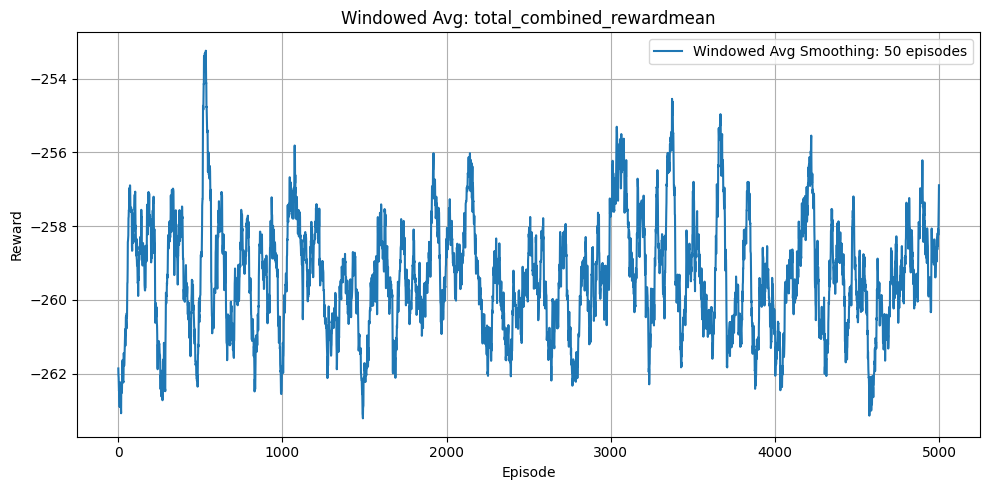

Shapiro wilk on the correlation are W = 0.7868060766004762, p = 0.006308384538891841
Alpha = 0.0 — Mean Spearman r = 0.001, SD = 0.009, t(10) = 0.49, p = 0.636, n = 11
In the condition with alpha = 0.0, a one-sample t-test revealed that the mean Spearman correlation between episode number and total reward was M = 0.001, SD = 0.009, which was not significant (t(10) = 0.49, p = 0.636). This suggests no evidence of learning across episodes.
In the condition with alpha = 0.0, the mean Shapiro-Wilk statistic for normality across simulations was W = 0.340, p < .001 (indicating non-normality in 0.0% of simulations).

--- Processing Group: see_emotions=True, alpha=0.5, beta=0.5, smoothing=linear, threshold=0.5, rounder=2, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=16, hidden_size=64, update_target_every=5 ---


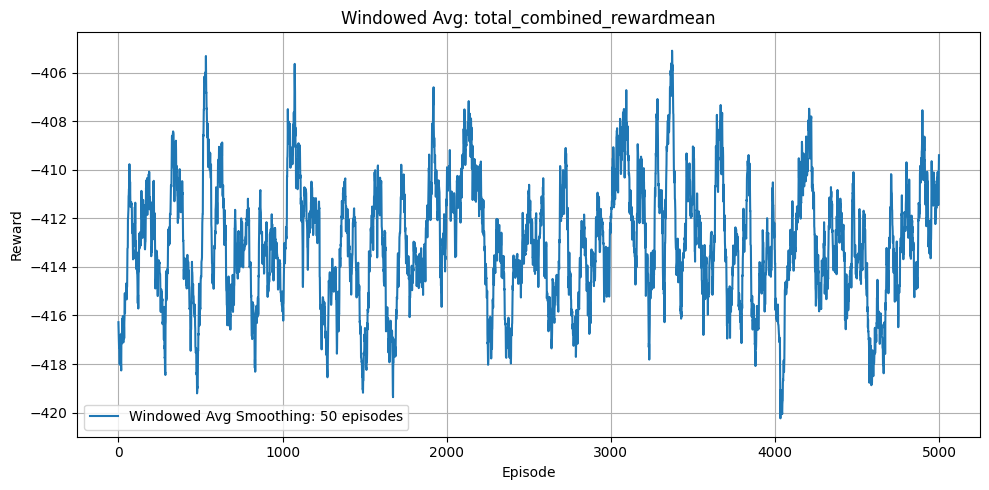

Shapiro wilk on the correlation are W = 0.8021223379636144, p = 0.01538549727065009
Alpha = 0.5 — Mean Spearman r = 0.001, SD = 0.009, t(9) = 0.24, p = 0.818, n = 10
In the condition with alpha = 0.5, a one-sample t-test revealed that the mean Spearman correlation between episode number and total reward was M = 0.001, SD = 0.009, which was not significant (t(9) = 0.24, p = 0.818). This suggests no evidence of learning across episodes.
In the condition with alpha = 0.5, the mean Shapiro-Wilk statistic for normality across simulations was W = 0.297, p < .001 (indicating non-normality in 0.0% of simulations).


In [26]:
# Define simulation parameters to group by
core_params = [
    'see_emotions', 'alpha', 'beta', 'smoothing', 'threshold', 'rounder',
    'learning_rate', 'gamma', 'epsilon', 'epsilon_decay', 'epsilon_min',
    'batch_size', 'hidden_size', 'update_target_every'
]

# Define reward prefix and simulation identifier + agregate columns
reward_column = "total_combined_reward"
simulation_column = "simulation_index"
df_gt_summary = sum_columns_by_format(df=df_maze_summary, prefix=reward_column)

# Iterate over all unique sets of parameter values
for param_values, group in df_gt_summary.groupby(core_params):
    label = ', '.join(f"{k}={v}" for k, v in zip(core_params, param_values))
    print(f"\n--- Processing Group: {label} ---")

    windowed_df = windowed_avg_combined_reward(
        df=group,
        reward_prefix=reward_column,
        episode_column="episode",
        simulation_id_column=simulation_column,
        window_size=50,
        aggregation_mode="mean",
        plot=True
    )

    df_learning = compute_episode_reward_correlation(
        df=group,
        simulation_column=simulation_column,
        reward_column=f"Sum_{reward_column}"  # summed reward column
    )

    for alpha_val in df_learning['type'].unique():
        subset_df = df_learning[df_learning['type'] == alpha_val]
        correlations = subset_df['correlation']
        n = len(correlations)

        shapiro_stat, shapiro_p = shapiro(correlations)
        print(f'Shapiro wilk on the correlation are W = {shapiro_stat}, p = {shapiro_p}')
        
        # t-test on correlations
        t_stat, p_val = ttest_1samp(correlations, 0)
        mean_r = correlations.mean()
        sd_r = correlations.std()
        
        # APA p formatting
        p_apa = "p < .001" if p_val < 0.001 else f"p = {p_val:.3f}"
        
        # Determine if test used was consistent (or mixed)
        test_used_set = set(subset_df['test_used'])
        test_used = test_used_set.pop() if len(test_used_set) == 1 else "Mixed"
    
        print(
            f"Alpha = {alpha_val} — Mean {test_used} r = {mean_r:.3f}, "
            f"SD = {sd_r:.3f}, t({n-1}) = {t_stat:.2f}, {p_apa}, n = {n}"
        )
        
        print(
            f"In the condition with alpha = {alpha_val}, a one-sample t-test revealed that "
            f"the mean {test_used} correlation between episode number and total reward was "
            f"M = {mean_r:.3f}, SD = {sd_r:.3f}, which was "
            f"{'significant' if p_val < 0.05 else 'not significant'} "
            f"(t({n-1}) = {t_stat:.2f}, {p_apa}). This suggests "
            f"{'a learning effect across episodes.' if p_val < 0.05 else 'no evidence of learning across episodes.'}"
        )
        
            # Shapiro-Wilk test: summarize W and p-values across simulations
        mean_W = subset_df['shapiro_stat'].mean()
        mean_shapiro_p = subset_df['shapiro_p'].mean()
        normal_fraction = (subset_df['shapiro_p'] > 0.05).mean()

        # APA p formatting for Shapiro
        p_shapiro_apa = "p < .001" if mean_shapiro_p < 0.001 else f"p = {mean_shapiro_p:.3f}"

        print(
            f"In the condition with alpha = {alpha_val}, "
            f"the mean Shapiro-Wilk statistic for normality across simulations was W = {mean_W:.3f}, {p_shapiro_apa} "
            f"(indicating {'normality' if mean_shapiro_p > 0.05 else 'non-normality'} in "
            f"{normal_fraction * 100:.1f}% of simulations)."
        )

## visualization

In [35]:
df_gt_summary.columns

df_gt_summary["resource_remaining"]

0          8.0
1         11.0
2         10.0
3          7.0
4          6.0
          ... 
104995    18.0
104996    12.0
104997     8.0
104998     6.0
104999    15.0
Name: resource_remaining, Length: 105000, dtype: float64


--- Processing Group: alpha=0.0 ---


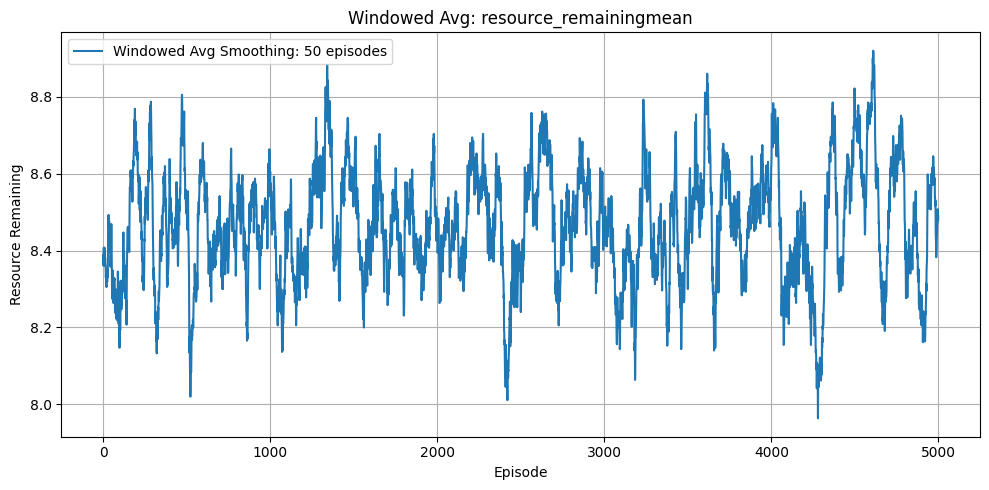


--- Processing Group: alpha=0.5 ---


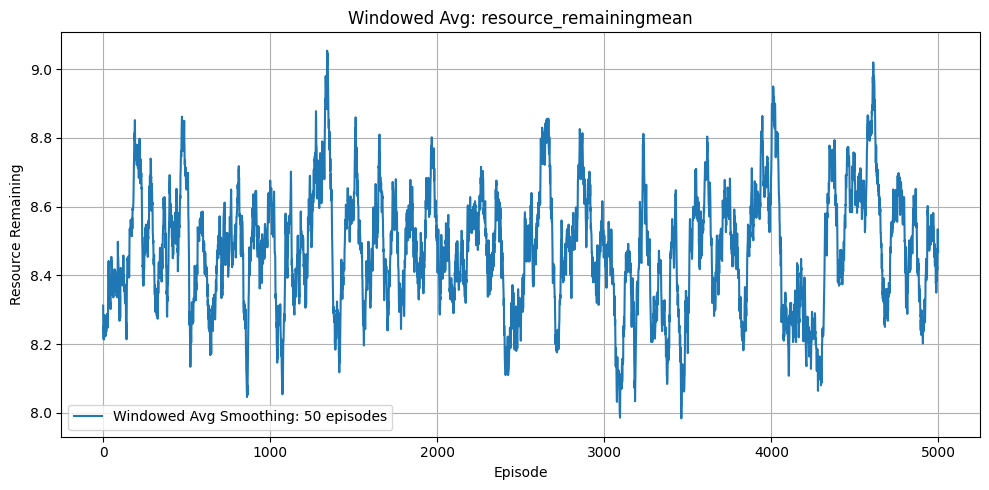

In [39]:
reward_column = "resource_remaining"
simulation_column = "simulation_index"
#df_gt_summary = sum_columns_by_format(df=df_maze_summary, prefix=reward_column)
core_params = ["alpha"]
# Iterate over all unique sets of parameter values
for param_values, group in df_gt_summary.groupby(core_params):
    label = ', '.join(f"{k}={v}" for k, v in zip(core_params, param_values))
    print(f"\n--- Processing Group: {label} ---")

    windowed_df = windowed_avg_combined_reward(
        df=group,
        reward_prefix=reward_column,
        episode_column="episode",
        simulation_id_column=simulation_column,
        window_size=50,
        aggregation_mode="mean",
        plot=True
    )



## Per simulation dataframe

In [30]:
df_gt_summary.columns

Index(['seed', 'episode', 'total_steps', 'resource_remaining',
       'total_personal_reward_0', 'total_personal_reward_1',
       'total_personal_reward_2', 'total_personal_reward_3',
       'total_personal_reward_4', 'total_personal_reward_5',
       'total_empathic_reward_0', 'total_empathic_reward_1',
       'total_empathic_reward_2', 'total_empathic_reward_3',
       'total_empathic_reward_4', 'total_empathic_reward_5',
       'total_combined_reward_0', 'total_combined_reward_1',
       'total_combined_reward_2', 'total_combined_reward_3',
       'total_combined_reward_4', 'total_combined_reward_5',
       'simulation_index', 'episodes', 'emotion', 'see_emotions', 'alpha',
       'beta', 'smoothing', 'threshold', 'rounder', 'learning_rate', 'gamma',
       'epsilon', 'epsilon_decay', 'epsilon_min', 'batch_size', 'hidden_size',
       'update_target_every', 'random_suffix', 'suffix', 'source', 'gini_coef',
       'total_personal_reward__averaged_efficiency',
       'Sum_total_combi

In [27]:
cols_to_convert = df_gt_summary.columns.difference(['see_emotions'])
df_gt_summary[cols_to_convert] = df_gt_summary[cols_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)
all_float_gt = df_gt_summary.dtypes.apply(lambda dt: np.issubdtype(dt, np.floating)).all()

In [28]:
df_summary_gt_simulation = summarize_simulations(df_gt_summary)
df_summary_gt_simulation = df_summary_gt_simulation.apply(pd.to_numeric, errors='coerce').astype(float)
all_float_summary = df_summary_gt_simulation.dtypes.apply(lambda dt: np.issubdtype(dt, np.floating)).all()

ValueError: Missing columns in input DataFrame: ['initial_resources', 'max_steps']

In [ ]:
print(df_summary_gt_simulation.shape)

(60, 9)


In [ ]:
print(df_summary_gt_simulation.columns)

Index(['simulation_number', 'alpha', 'see_emotions', 'total_steps',
       'initial_resources', 'step_number_depletion',
       'resource_quantity_depletion', 'efficiency_metric', 'gini_coef'],
      dtype='object')


## Data Analysis

### T-test

#### By variable computation

##### Ressource depletion test

In [ ]:
group0 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0]['step_number_depletion'].dropna()
group05 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0.5]['step_number_depletion'].dropna()

print("Variable: step_number_depletion")

mean0, mean05 = group0.mean(), group05.mean()
median0, median05 = group0.median(), group05.median()
std0, std05 = group0.std(ddof=1), group05.std(ddof=1)
n0, n05 = len(group0), len(group05)

print(f"Group alpha=0: mean={mean0:.4f}, median={median0:.4f}, std={std0:.6f}, n={n0}")
print(f"Group alpha=0.5: mean={mean05:.4f}, median={median05:.4f}, std={std05:.6f}, n={n05}")

stat0, p0 = shapiro(group0)
stat05, p05 = shapiro(group05)
print(f"Shapiro-Wilk normality p-values: alpha=0 -> {p0:.4f}, alpha=0.5 -> {p05:.4f}")

normal0 = p0 > 0.05
normal05 = p05 > 0.05

stat_levene, p_levene = levene(group0, group05)
print(f"Levene’s test for equal variances p-value: {p_levene:.4f}")
equal_var = p_levene > 0.05

if normal0 and normal05:
    stat_t, p_t = ttest_ind(group0, group05, equal_var=equal_var)
    pooled_std = np.sqrt(
        ((n0 - 1)*std0**2 + (n05 - 1)*std05**2) / (n0 + n05 - 2)
    )
    cohen_d = (mean0 - mean05) / pooled_std
    print(f"T-test: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.4f}, Cohen's d = {cohen_d:.2f}")
    print(f"APA style result: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.3f}, d = {cohen_d:.2f}.")
else:
    stat_mw, p_mw = mannwhitneyu(group0, group05, alternative='two-sided')
    mean_U = n0 * n05 / 2
    std_U = np.sqrt(n0 * n05 * (n0 + n05 + 1) / 12)
    z = (stat_mw - mean_U) / std_U
    r = abs(z) / np.sqrt(n0 + n05)
    print(f"Mann-Whitney U = {stat_mw}, p = {p_mw:.4f}, effect size r = {r:.2f}")
    print(f"APA style result: U = {stat_mw:.0f}, p = {p_mw:.3f}, r = {r:.2f}.")


Variable: step_number_depletion
Group alpha=0: mean=0.3658, median=0.3663, std=0.004921, n=30
Group alpha=0.5: mean=0.1399, median=0.1391, std=0.007367, n=30
Shapiro-Wilk normality p-values: alpha=0 -> 0.8721, alpha=0.5 -> 0.7837
Levene’s test for equal variances p-value: 0.0380
T-test: t(58) = 139.68, p = 0.0000, Cohen's d = 36.07
APA style result: t(58) = 139.68, p = 0.000, d = 36.07.


In [ ]:
group0 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0]['resource_quantity_depletion'].dropna()
group05 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0.5]['resource_quantity_depletion'].dropna()
print("Variable: resource_quantity_depletion")

mean0, mean05 = group0.mean(), group05.mean()
median0, median05 = group0.median(), group05.median()
std0, std05 = group0.std(ddof=1), group05.std(ddof=1)
n0, n05 = len(group0), len(group05)

print(f"Group alpha=0: mean={mean0:.4f}, median={median0:.4f}, std={std0:.6f}, n={n0}")
print(f"Group alpha=0.5: mean={mean05:.4f}, median={median05:.4f}, std={std05:.6f}, n={n05}")

stat0, p0 = shapiro(group0)
stat05, p05 = shapiro(group05)
print(f"Shapiro-Wilk normality p-values: alpha=0 -> {p0:.4f}, alpha=0.5 -> {p05:.4f}")

normal0 = p0 > 0.05
normal05 = p05 > 0.05

stat_levene, p_levene = levene(group0, group05)
print(f"Levene’s test for equal variances p-value: {p_levene:.4f}")
equal_var = p_levene > 0.05

if normal0 and normal05:
    stat_t, p_t = ttest_ind(group0, group05, equal_var=equal_var)
    pooled_std = np.sqrt(
        ((n0 - 1)*std0**2 + (n05 - 1)*std05**2) / (n0 + n05 - 2)
    )
    cohen_d = (mean0 - mean05) / pooled_std
    print(f"T-test: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.4f}, Cohen's d = {cohen_d:.2f}")
    print(f"APA style result: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.3f}, d = {cohen_d:.2f}.")
else:
    stat_mw, p_mw = mannwhitneyu(group0, group05, alternative='two-sided')
    mean_U = n0 * n05 / 2
    std_U = np.sqrt(n0 * n05 * (n0 + n05 + 1) / 12)
    z = (stat_mw - mean_U) / std_U
    r = abs(z) / np.sqrt(n0 + n05)
    print(f"Mann-Whitney U = {stat_mw}, p = {p_mw:.4f}, effect size r = {r:.2f}")
    print(f"APA style result: U = {stat_mw:.0f}, p = {p_mw:.3f}, r = {r:.2f}.")


Variable: resource_quantity_depletion
Group alpha=0: mean=1.0000, median=1.0000, std=0.000010, n=30
Group alpha=0.5: mean=0.9994, median=0.9994, std=0.000064, n=30
Shapiro-Wilk normality p-values: alpha=0 -> 0.1502, alpha=0.5 -> 0.7127
Levene’s test for equal variances p-value: 0.0000
T-test: t(58) = 51.31, p = 0.0000, Cohen's d = 13.25
APA style result: t(58) = 51.31, p = 0.000, d = 13.25.


##### Fairness : gini_coef

In [ ]:
group0 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0]['gini_coef'].dropna()
group05 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0.5]['gini_coef'].dropna()
print("Variable: gini_coef")

mean0, mean05 = group0.mean(), group05.mean()
median0, median05 = group0.median(), group05.median()
std0, std05 = group0.std(ddof=1), group05.std(ddof=1)
n0, n05 = len(group0), len(group05)

print(f"Group alpha=0: mean={mean0:.4f}, median={median0:.4f}, std={std0:.6f}, n={n0}")
print(f"Group alpha=0.5: mean={mean05:.4f}, median={median05:.4f}, std={std05:.6f}, n={n05}")

stat0, p0 = shapiro(group0)
stat05, p05 = shapiro(group05)
print(f"Shapiro-Wilk normality p-values: alpha=0 -> {p0:.4f}, alpha=0.5 -> {p05:.4f}")

normal0 = p0 > 0.05
normal05 = p05 > 0.05

stat_levene, p_levene = levene(group0, group05)
print(f"Levene’s test for equal variances p-value: {p_levene:.4f}")
equal_var = p_levene > 0.05

if normal0 and normal05:
    stat_t, p_t = ttest_ind(group0, group05, equal_var=equal_var)
    pooled_std = np.sqrt(
        ((n0 - 1)*std0**2 + (n05 - 1)*std05**2) / (n0 + n05 - 2)
    )
    cohen_d = (mean0 - mean05) / pooled_std
    print(f"T-test: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.4f}, Cohen's d = {cohen_d:.2f}")
    print(f"APA style result: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.3f}, d = {cohen_d:.2f}.")
else:
    stat_mw, p_mw = mannwhitneyu(group0, group05, alternative='two-sided')
    mean_U = n0 * n05 / 2
    std_U = np.sqrt(n0 * n05 * (n0 + n05 + 1) / 12)
    z = (stat_mw - mean_U) / std_U
    r = abs(z) / np.sqrt(n0 + n05)
    print(f"Mann-Whitney U = {stat_mw}, p = {p_mw:.4f}, effect size r = {r:.2f}")
    print(f"APA style result: U = {stat_mw:.0f}, p = {p_mw:.3f}, r = {r:.2f}.")


Variable: gini_coef
Group alpha=0: mean=0.0522, median=0.0521, std=0.000794, n=30
Group alpha=0.5: mean=0.1443, median=0.1437, std=0.004386, n=30
Shapiro-Wilk normality p-values: alpha=0 -> 0.1450, alpha=0.5 -> 0.8595
Levene’s test for equal variances p-value: 0.0000
T-test: t(58) = -113.18, p = 0.0000, Cohen's d = -29.22
APA style result: t(58) = -113.18, p = 0.000, d = -29.22.


##### Efficiency_metric

In [ ]:
group0 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0]['efficiency_metric'].dropna()
group05 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0.5]['efficiency_metric'].dropna()
print("Variable: efficiency_metric")

mean0, mean05 = group0.mean(), group05.mean()
median0, median05 = group0.median(), group05.median()
std0, std05 = group0.std(ddof=1), group05.std(ddof=1)
n0, n05 = len(group0), len(group05)

print(f"Group alpha=0: mean={mean0:.4f}, median={median0:.4f}, std={std0:.6f}, n={n0}")
print(f"Group alpha=0.5: mean={mean05:.4f}, median={median05:.4f}, std={std05:.6f}, n={n05}")

stat0, p0 = shapiro(group0)
stat05, p05 = shapiro(group05)
print(f"Shapiro-Wilk normality p-values: alpha=0 -> {p0:.4f}, alpha=0.5 -> {p05:.4f}")

normal0 = p0 > 0.05
normal05 = p05 > 0.05

stat_levene, p_levene = levene(group0, group05)
print(f"Levene’s test for equal variances p-value: {p_levene:.4f}")
equal_var = p_levene > 0.05

if normal0 and normal05:
    stat_t, p_t = ttest_ind(group0, group05, equal_var=equal_var)
    pooled_std = np.sqrt(
        ((n0 - 1)*std0**2 + (n05 - 1)*std05**2) / (n0 + n05 - 2)
    )
    cohen_d = (mean0 - mean05) / pooled_std
    print(f"T-test: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.4f}, Cohen's d = {cohen_d:.2f}")
    print(f"APA style result: t({n0 + n05 - 2}) = {stat_t:.2f}, p = {p_t:.3f}, d = {cohen_d:.2f}.")
else:
    stat_mw, p_mw = mannwhitneyu(group0, group05, alternative='two-sided')
    mean_U = n0 * n05 / 2
    std_U = np.sqrt(n0 * n05 * (n0 + n05 + 1) / 12)
    z = (stat_mw - mean_U) / std_U
    r = abs(z) / np.sqrt(n0 + n05)
    print(f"Mann-Whitney U = {stat_mw}, p = {p_mw:.4f}, effect size r = {r:.2f}")
    print(f"APA style result: U = {stat_mw:.0f}, p = {p_mw:.3f}, r = {r:.2f}.")


Variable: efficiency_metric
Group alpha=0: mean=0.1313, median=0.1314, std=0.001020, n=30
Group alpha=0.5: mean=0.0968, median=0.0967, std=0.000834, n=30
Shapiro-Wilk normality p-values: alpha=0 -> 0.8485, alpha=0.5 -> 0.7389
Levene’s test for equal variances p-value: 0.3824
T-test: t(58) = 143.47, p = 0.0000, Cohen's d = 37.04
APA style result: t(58) = 143.47, p = 0.000, d = 37.04.


#### All variables computed at once

In [ ]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx -1)*np.var(x, ddof=1) + (ny -1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def rank_biserial_u(u_stat, n1, n2):
    # Convert Mann-Whitney U to rank-biserial correlation
    return 1 - (2 * u_stat) / (n1 * n2)

variables = ['step_number_depletion', 'resource_quantity_depletion', 'gini_coef', 'efficiency_metric']
alphas = [0, 0.5]

for var in variables:
    print(f"=== Variable: {var} ===")
    
    group0 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0][var].dropna()
    group05 = df_summary_gt_simulation[df_summary_gt_simulation['alpha'] == 0.5][var].dropna()

    # Descriptive stats
    def describe_group(g):
        return {
            'n': len(g),
            'mean': np.mean(g),
            'std': np.std(g, ddof=1),
            'median': np.median(g)
        }

    desc0 = describe_group(group0)
    desc05 = describe_group(group05)

    print(f"Group alpha=0: n={desc0['n']}, mean={desc0['mean']:.3f}, SD={desc0['std']:.3f}, median={desc0['median']:.3f}")
    print(f"Group alpha=0.5: n={desc05['n']}, mean={desc05['mean']:.3f}, SD={desc05['std']:.3f}, median={desc05['median']:.3f}")

    # Levene test
    stat_levene, p_levene = levene(group0, group05)
    levene_interpret = "equal variances assumed" if p_levene > 0.05 else "unequal variances"
    print(f"Levene's test: F({desc0['n']-1}, {desc05['n']-1}) = {stat_levene:.3f}, p = {p_levene:.3f} ({levene_interpret}).")

    # Shapiro-Wilk normality tests
    norm0_stat, norm0_p = shapiro(group0)
    norm05_stat, norm05_p = shapiro(group05)
    norm0_interpret = "normal" if norm0_p > 0.05 else "non-normal"
    norm05_interpret = "normal" if norm05_p > 0.05 else "non-normal"
    print(f"Shapiro-Wilk (alpha=0): W = {norm0_stat:.3f}, p = {norm0_p:.3f} ({norm0_interpret}).")
    print(f"Shapiro-Wilk (alpha=0.5): W = {norm05_stat:.3f}, p = {norm05_p:.3f} ({norm05_interpret}).")

    # Decide test based on Levene and normality
    if norm0_p > 0.05 and norm05_p > 0.05:
        # Both normal
        if p_levene > 0.05:
            # equal variance t-test
            t_stat, p_val = ttest_ind(group0, group05, equal_var=True)
            test_name = "Student's t-test"
        else:
            # Welch's t-test
            t_stat, p_val = ttest_ind(group0, group05, equal_var=False)
            test_name = "Welch's t-test"

        d = cohen_d(group0, group05)
        print(f"{test_name}: t = {t_stat:.3f}, p = {p_val:.3f}, Cohen's d = {d:.3f}")

    else:
        # Use Mann-Whitney U
        u_stat, p_val = mannwhitneyu(group0, group05, alternative='two-sided')
        rbc = rank_biserial_u(u_stat, desc0['n'], desc05['n'])
        print(f"Mann-Whitney U test: U = {u_stat}, p = {p_val:.3f}, rank-biserial correlation = {rbc:.3f}")

    print("\n" + "-"*50 + "\n")


=== Variable: step_number_depletion ===
Group alpha=0: n=30, mean=0.366, SD=0.005, median=0.366
Group alpha=0.5: n=30, mean=0.140, SD=0.007, median=0.139
Levene's test: F(29, 29) = 4.511, p = 0.038 (unequal variances).
Shapiro-Wilk (alpha=0): W = 0.982, p = 0.872 (normal).
Shapiro-Wilk (alpha=0.5): W = 0.978, p = 0.784 (normal).
Welch's t-test: t = 139.684, p = 0.000, Cohen's d = 36.066

--------------------------------------------------

=== Variable: resource_quantity_depletion ===
Group alpha=0: n=30, mean=1.000, SD=0.000, median=1.000
Group alpha=0.5: n=30, mean=0.999, SD=0.000, median=0.999
Levene's test: F(29, 29) = 35.813, p = 0.000 (unequal variances).
Shapiro-Wilk (alpha=0): W = 0.948, p = 0.150 (normal).
Shapiro-Wilk (alpha=0.5): W = 0.976, p = 0.713 (normal).
Welch's t-test: t = 51.306, p = 0.000, Cohen's d = 13.247

--------------------------------------------------

=== Variable: gini_coef ===
Group alpha=0: n=30, mean=0.052, SD=0.001, median=0.052
Group alpha=0.5: n=30, m

### Eploratory averaged per episode


--- Processing Group: alpha=0.0 ---


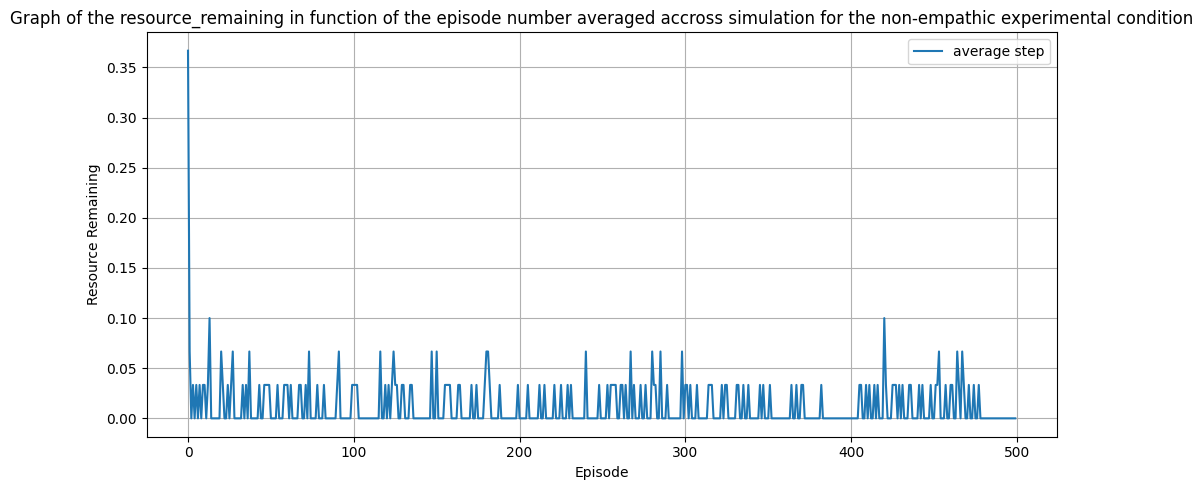

Alpha = 0.0 — Mean Spearman r = -0.023, SD = 0.053, t(29) = -2.37, p = 0.025, n = 30
Shapiro Wilk : W = 0.10762312105657883, p = 1.7742831849020654e-42, proportion normal = 0.0
Mean correlation (r) = -0.023, Standard Deviation = 0.053
Average resource_remaining = 0.01 ; SD = 0.11
In the condition with alpha = 0.0, a one-sample t-test revealed that the mean Spearman correlation between episode number and 'resource_remaining' was M = -0.023, SD = 0.053, which was significant (t(29) = -2.37, p = 0.025). This suggests decreasing depletion (i.e., learning or improved resource conservation)

--- Processing Group: alpha=0.5 ---


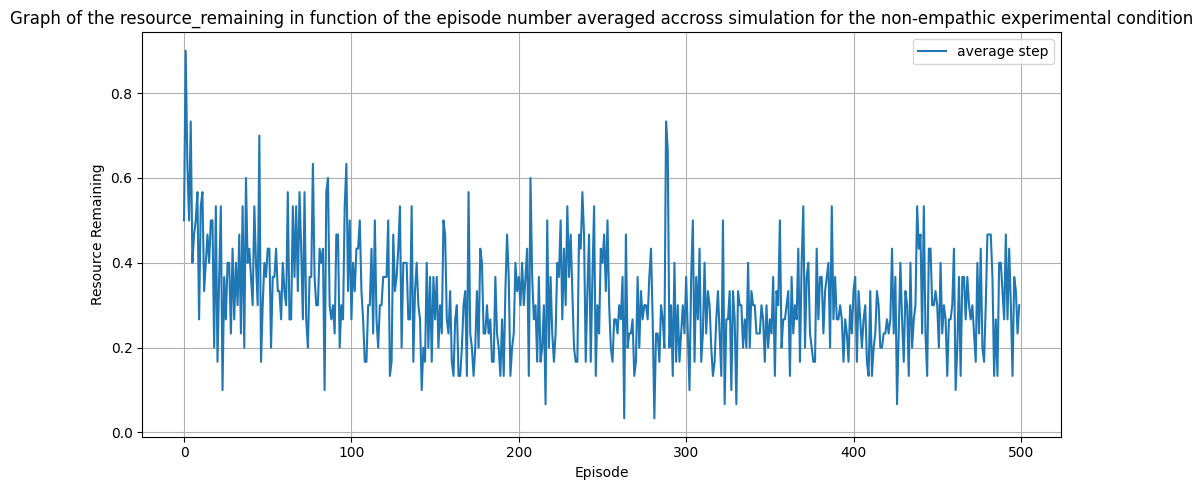

Alpha = 0.5 — Mean Spearman r = -0.057, SD = 0.053, t(29) = -5.86, p < .001, n = 30
Shapiro Wilk : W = 0.6287287480671059, p = 7.804260492514597e-28, proportion normal = 0.0
Mean correlation (r) = -0.057, Standard Deviation = 0.053
Average resource_remaining = 0.31 ; SD = 0.58
In the condition with alpha = 0.5, a one-sample t-test revealed that the mean Spearman correlation between episode number and 'resource_remaining' was M = -0.057, SD = 0.053, which was significant (t(29) = -5.86, p < .001). This suggests decreasing depletion (i.e., learning or improved resource conservation)


In [ ]:
# Define simulation parameters to group by
param_diff = 'alpha'
column_tested = 'resource_remaining'  # Column we are analyzing
simulation_column = 'simulation_index'         # Simulation ID column


# Iterate over all unique sets of parameter values
grouped = df_gt_summary.groupby([param_diff])

for param_values, group in grouped:
    # If grouping by one param, param_values is a scalar, not tuple
    if isinstance(param_values, tuple):
        label = ', '.join(f"{k}={v}" for k, v in zip([param_diff], param_values))
    else:
        label = f"{param_diff}={param_values}"
    print(f"\n--- Processing Group: {label} ---")

    if param_values == 0.5:
        condition = 'empathic'
    else: 
        condition = 'non-empathic'
    

    # Plot the trend of the tested column (works for both multi-agent and single columns)
    windowed_df = windowed_avg_combined_reward(
        df=group,
        reward_prefix=column_tested,
        episode_column="episode",
        simulation_id_column=simulation_column,
        window_size=1,
        aggregation_mode="mean",  # Only used if multi-agent
        plot=True,
        title=f'Graph of the {column_tested} in function of the episode number averaged accross simulation for the {condition} experimental condition',
        legend='average step'
    )

    # Compute correlations between episode number and the tested variable
    df_learning = compute_episode_reward_correlation(
        df=group,
        simulation_column=simulation_column,
        reward_column=column_tested
    )

    # Analyze by alpha value (or type)
    for alpha_val in df_learning['type'].unique():
        subset_df = df_learning[df_learning['type'] == alpha_val]
        correlations = subset_df['correlation']
        n = len(correlations)

        # Perform one-sample t-test on the correlations
        t_stat, p_val = ttest_1samp(correlations, 0)
        mean_r = correlations.mean()
        sd_r = correlations.std()

        # Format p-value APA style
        p_apa = "p < .001" if p_val < 0.001 else f"p = {p_val:.3f}"

        # Identify the correlation test used
        test_used_set = set(subset_df['test_used'])
        test_used = test_used_set.pop() if len(test_used_set) == 1 else "Mixed"

        print(
            f"Alpha = {alpha_val} — Mean {test_used} r = {mean_r:.3f}, "
            f"SD = {sd_r:.3f}, t({n-1}) = {t_stat:.2f}, {p_apa}, n = {n}"
        )

        # Report Shapiro-Wilk normality statistics
        mean_W = subset_df['shapiro_stat'].mean()
        mean_shapiro_p = subset_df['shapiro_p'].mean()
        normal_fraction = (subset_df['shapiro_p'] > 0.05).mean()

        p_shapiro_apa = "p < .001" if mean_shapiro_p < 0.001 else f"p = {mean_shapiro_p:.3f}"


        print(f'Shapiro Wilk : W = {mean_W}, p = {mean_shapiro_p}, proportion normal = {normal_fraction}')

        print(
            f"Mean correlation (r) = {mean_r:.3f}, Standard Deviation = {sd_r:.3f}"
        )

        print(f"Average {column_tested} = {group[column_tested].mean():.2f} ; SD = {group[column_tested].std():.2f}")


        print(
            f"In the condition with alpha = {alpha_val}, a one-sample t-test revealed that "
            f"the mean {test_used} correlation between episode number and '{column_tested}' was "
            f"M = {mean_r:.3f}, SD = {sd_r:.3f}, which was "
            f"{'significant' if p_val < 0.05 else 'not significant'} "
            f"(t({n-1}) = {t_stat:.2f}, {p_apa}). This suggests "
            f"{'increasing depletion (i.e., worsening behavior)' if p_val < 0.05 and mean_r > 0 else ''}"
            f"{'decreasing depletion (i.e., learning or improved resource conservation)' if p_val < 0.05 and mean_r < 0 else ''}"
            f"{'no consistent trend in depletion over time.' if p_val >= 0.05 else ''}"
        )




--- Processing Group: alpha=0.0 ---


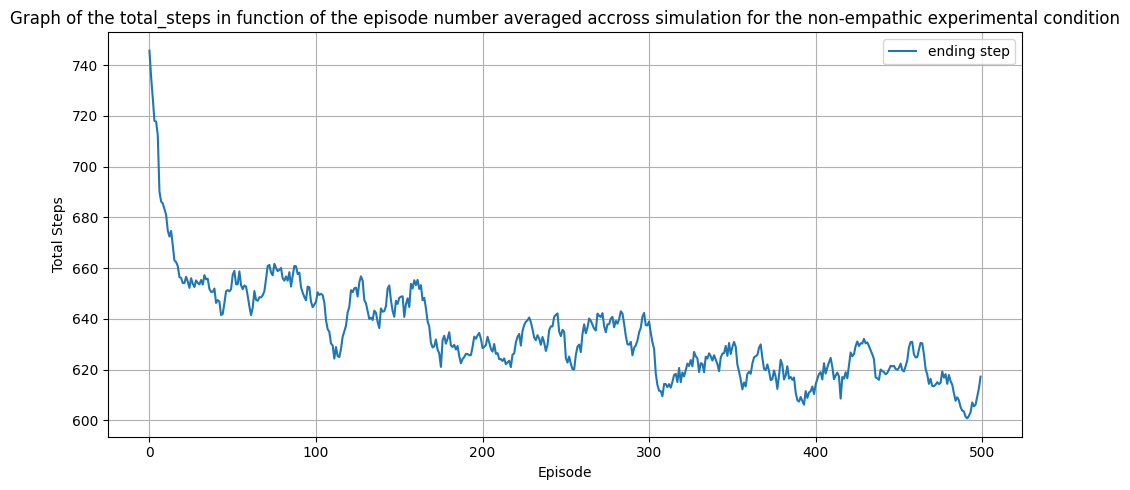

Alpha = 0.0 — Mean Spearman r = -0.131, SD = 0.050, t(29) = -14.27, p < .001, n = 30
Shapiro Wilk : W = 0.9533134268841715, p = 3.700715392771337e-10, proportion normal = 0.0
Mean correlation (r) = -0.131, Standard Deviation = 0.050
Average total_steps = 634.19 ; SD = 116.71
In the condition with alpha = 0.0, a one-sample t-test revealed that the mean Spearman correlation between episode number and 'total_steps' was M = -0.131, SD = 0.050, which was significant (t(29) = -14.27, p < .001). This suggests increasing depletion

--- Processing Group: alpha=0.5 ---


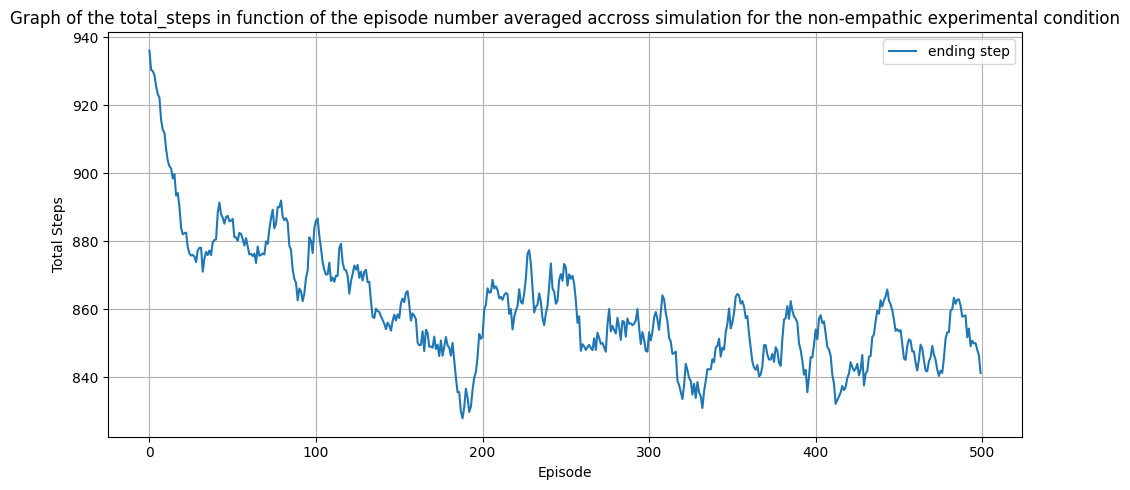

Alpha = 0.5 — Mean Spearman r = -0.092, SD = 0.058, t(29) = -8.73, p < .001, n = 30
Shapiro Wilk : W = 0.9285952052165914, p = 2.2148201799587225e-11, proportion normal = 0.0
Mean correlation (r) = -0.092, Standard Deviation = 0.058
Average total_steps = 860.11 ; SD = 125.35
In the condition with alpha = 0.5, a one-sample t-test revealed that the mean Spearman correlation between episode number and 'total_steps' was M = -0.092, SD = 0.058, which was significant (t(29) = -8.73, p < .001). This suggests increasing depletion


In [ ]:
# Define simulation parameters to group by
param_diff = 'alpha'
column_tested = 'total_steps'  # Column we are analyzing
simulation_column = 'simulation_index'         # Simulation ID column


# Iterate over all unique sets of parameter values
grouped = df_gt_summary.groupby([param_diff])

for param_values, group in grouped:
    # If grouping by one param, param_values is a scalar, not tuple
    if isinstance(param_values, tuple):
        label = ', '.join(f"{k}={v}" for k, v in zip([param_diff], param_values))
    else:
        label = f"{param_diff}={param_values}"
    print(f"\n--- Processing Group: {label} ---")

    if param_values == 0.5:
        condition = 'empathic'
    else: 
        condition = 'non-empathic'

    # Plot the trend of the tested column (works for both multi-agent and single columns)
    windowed_df = windowed_avg_combined_reward(
        df=group,
        reward_prefix=column_tested,
        episode_column="episode",
        simulation_id_column=simulation_column,
        window_size=10,
        aggregation_mode="mean",  # Only used if multi-agent
        plot=True,
        title=f'Graph of the {column_tested} in function of the episode number averaged accross simulation for the {condition} experimental condition',
        legend='ending step'
    )


    # Compute correlations between episode number and the tested variable
    df_learning = compute_episode_reward_correlation(
        df=group,
        simulation_column=simulation_column,
        reward_column=column_tested
    )

    # Analyze by alpha value (or type)
    for alpha_val in df_learning['type'].unique():
        subset_df = df_learning[df_learning['type'] == alpha_val]
        correlations = subset_df['correlation']
        n = len(correlations)

        # Perform one-sample t-test on the correlations
        t_stat, p_val = ttest_1samp(correlations, 0)
        mean_r = correlations.mean()
        sd_r = correlations.std()

        # Format p-value APA style
        p_apa = "p < .001" if p_val < 0.001 else f"p = {p_val:.3f}"

        # Identify the correlation test used
        test_used_set = set(subset_df['test_used'])
        test_used = test_used_set.pop() if len(test_used_set) == 1 else "Mixed"

        print(
            f"Alpha = {alpha_val} — Mean {test_used} r = {mean_r:.3f}, "
            f"SD = {sd_r:.3f}, t({n-1}) = {t_stat:.2f}, {p_apa}, n = {n}"
        )

        # Report Shapiro-Wilk normality statistics
        mean_W = subset_df['shapiro_stat'].mean()
        mean_shapiro_p = subset_df['shapiro_p'].mean()
        normal_fraction = (subset_df['shapiro_p'] > 0.05).mean()

        p_shapiro_apa = "p < .001" if mean_shapiro_p < 0.001 else f"p = {mean_shapiro_p:.3f}"

        print(f'Shapiro Wilk : W = {mean_W}, p = {mean_shapiro_p}, proportion normal = {normal_fraction}')

        print(
            f"Mean correlation (r) = {mean_r:.3f}, Standard Deviation = {sd_r:.3f}"
        )

        print(f"Average {column_tested} = {group[column_tested].mean():.2f} ; SD = {group[column_tested].std():.2f}")


        print(
            f"In the condition with alpha = {alpha_val}, a one-sample t-test revealed that "
            f"the mean {test_used} correlation between episode number and '{column_tested}' was "
            f"M = {mean_r:.3f}, SD = {sd_r:.3f}, which was "
            f"{'significant' if p_val < 0.05 else 'not significant'} "
            f"(t({n-1}) = {t_stat:.2f}, {p_apa}). This suggests "
            f"{'increasing depletion' if p_val < 0.05 and mean_r < 0 else ''}"
            f"{'decreasing depletion ' if p_val < 0.05 and mean_r > 0 else ''}"
            f"{'no consistent trend in depletion over time.' if p_val >= 0.05 else ''}"
        )